# Peer-graded Assignment: Segmenting and Clustering Neighborhoods in Toronto

**Aleksandr Plotnikow** 



First we get raw data from wikipedia to dataframe called df

In [1]:
import sys
!{sys.executable} -m pip install geocoder


In [2]:
#!conda install -c conda-forge folium=0.5.0 --yes

In [3]:
import pandas as pd
import numpy as np
import requests
import geocoder

from pandas.io.json import json_normalize
import folium 
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wiki = requests.get(url).content
df_list = pd.read_html(wiki,header=0)[0]
df = df_list
df.head()


,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


We get rid of 'Not assigned' and rename columns as in the course

In [4]:
df.drop(df.loc[df['Borough']=='Not assigned'].index, inplace=True)
df.rename(columns = {'Postal Code':'PostalCode'}, inplace = True)
df.rename(columns = {'Neighbourhood':'Neighborhood'}, inplace = True)
df.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"



Grouping data and reseting index 

In [5]:
df_new = df.groupby(['PostalCode','Borough'])['Neighborhood'].apply(lambda x: ', '.join(x)).reset_index()
df_new.head()


,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [6]:
df.shape

(103, 3)

In [ ]:
attempt to use geocoder, but apparently when I tried it, it just never connected, so I used given data of localisation

In [7]:
def get_geocode(postal_code):
  
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    return latitude,longitude

In [8]:
geo_data=pd.read_csv('http://cocl.us/Geospatial_data')

Rename columns

In [9]:

geo_data.rename(columns = {'Postal Code':'PostalCode'}, inplace = True)



In [10]:
geo_data.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merge DataFrame with coordinates by PostalCode

In [11]:
df_cor = pd.merge(df, geo_data, on = "PostalCode")

df_cor.head()


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Separating other borough (such as New York) from Toronto.
Then we get coordianates (average of Toronto) to find our map

In [12]:
df_toronto = df_cor[df_cor['Borough'].str.contains('Toronto',regex=False)]
Box = (df_toronto.Latitude.mean(), df_toronto.Longitude.mean())
Box[0]

43.66713498717949

Using Folium to get a map, according to mean value of coordinates of Toronto data

In [13]:
map_toronto = folium.Map(location=[Box[0],Box[1]],zoom_start=12)

for lat,lng,borough,neighborhood in zip(df_toronto['Latitude'],df_toronto['Longitude'],df_toronto['Borough'],df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='green',
    fill_opacity=0.6,
    parse_html=False).add_to(map_toronto)
map_toronto

In [14]:
df_cluster = df_toronto[['Latitude','Longitude']]
df_cluster

,Latitude,Longitude
2,43.654260,-79.360636
4,43.662301,-79.389494
9,43.657162,-79.378937
15,43.651494,-79.375418
19,43.676357,-79.293031
20,43.644771,-79.373306
24,43.657952,-79.387383
25,43.669542,-79.422564
30,43.650571,-79.384568
31,43.669005,-79.442259


I decided to diuvide into 4 clusters

In [15]:
k = 4
kmeans = KMeans(n_clusters=k).fit(df_cluster)
centroids = kmeans.cluster_centers_
kmeans.labels_


array([2, 2, 2, 2, 0, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 0, 2, 0, 3, 3, 3, 3,
       1, 3, 2, 1, 3, 2, 1, 3, 2, 3, 2, 2, 2, 2, 2, 2, 0], dtype=int32)

Merge Cluster value with DataFrame of Toronto

In [16]:
df_toronto.insert(0, 'Cluster Labels', kmeans.labels_)

df_toronto.head()

,Cluster Labels,PostalCode,Borough,Neighborhood,Latitude,Longitude
2,2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,2,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,0,M4E,East Toronto,The Beaches,43.676357,-79.293031


The red dots represents cluster centroids

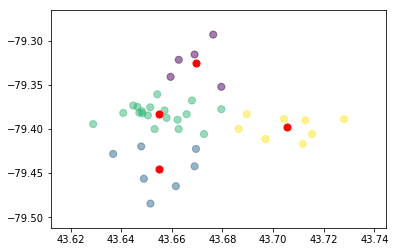

In [17]:
plt.scatter(df_cluster['Latitude'], df_cluster['Longitude'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

Map with clusters

In [19]:

map_cluster = folium.Map(location=[Box[0],Box[1]],zoom_start=12)


x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


markers_colors = []
for lat, lon, neighbourhood, cluster in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighborhood'], df_toronto['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster) + ', ' + neighbourhood, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color='green',
        fill_opacity=0.5).add_to(map_cluster)
       
map_cluster